## Flower Image Prediction Competition

## 1. Get data in and set up X_train, X_test, y_train objects

In [ ]:
#install aimodelshare library
! pip install aimodelshare --upgrade

     |████████████████████████████████| 121 kB 36.0 MB/s 
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |████████████████████████████████| 146 kB 67.1 MB/s 
     |████████████████████████████████| 4.9 MB 53.9 MB/s 
     |████████████████████████████████| 127 kB 52.7 MB/s 
     |████████████████████████████████| 78 kB 5.4 MB/s 
     |████████████████████████████████| 435 kB 50.8 MB/s 
     |████████████████████████████████| 12.7 MB 51.0 MB/s 
     |████████████████████████████████| 178 kB 54.1 MB/s 
     |████████████████████████████████| 271 kB 50.0 MB/s 
     |████████████████████████████████| 22.3 MB 1.7 MB/s 
     |████████████████████████████████| 131 kB 64.8 MB/s 
     |████████████████████████████████| 7.7 MB 50.2 MB/s 
     |████████████████████████████████| 300 kB 72.3 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 87 kB 6.3 MB/s 
  Created wheel for Pym

In [ ]:
# Get competition data
from aimodelshare import download_data

download_data('public.ecr.aws/x8e4b0t0/flower_competition_data-repository:latest') 


Data downloaded successfully.


##2.   Preprocess data  / Write and Save Preprocessor function


In [ ]:
def preprocessor(image_filepath, shape=(192, 192)):
        
        import cv2
        import numpy as np

        img = cv2.imread(image_filepath) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize all the images.
        X = np.array(img)
        X = np.expand_dims(X, axis=0) 
        X = np.array(X, dtype=np.float32) 
        return X

In [ ]:
base_path = 'flower_competition_data/train_images'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

import os

fnames = []

for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)


In [ ]:
trainingdata_filepaths=fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]

preprocessed_image_data = [preprocessor(x) for x in trainingdata_filepaths]

import numpy as np
X = np.vstack(preprocessed_image_data) 

X.shape

(2936, 192, 192, 3)

In [ ]:
from itertools import repeat

daisy = list(repeat("daisy", 507)) 
dandelion = list(repeat("dandelion", 718))
roses = list(repeat("roses", 513))
sunflowers = list(repeat("sunflowers", 559))
tulips = list(repeat("tulips", 639))

y_labels = daisy + dandelion + roses + sunflowers + tulips

len(y_labels) 

import pandas as pd
y = pd.get_dummies(y_labels)
display(y)

,daisy,dandelion,roses,sunflowers,tulips
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2931,0,0,0,0,1
2932,0,0,0,0,1
2933,0,0,0,0,1
2934,0,0,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20)

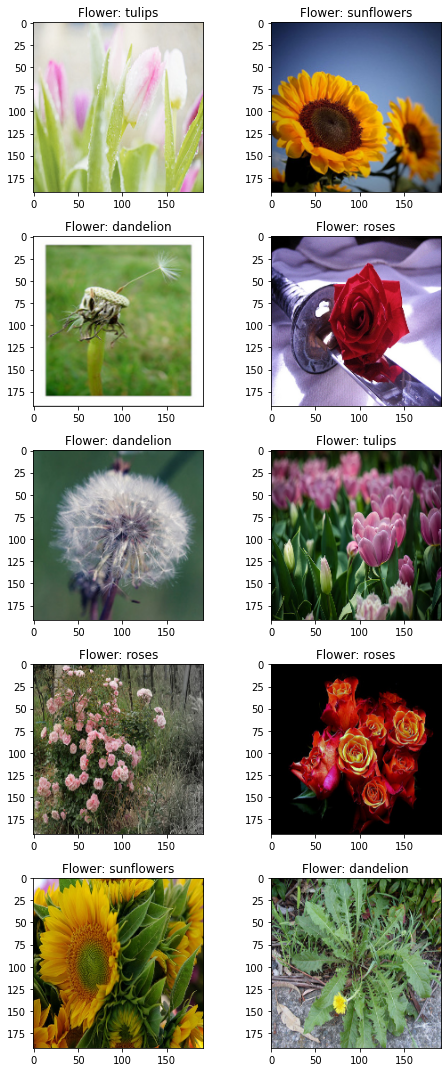

In [ ]:
# Visualize images

%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(7, 15)
for i in range(5):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + y_labels[l])
        
plt.tight_layout()



##3. Fit model on preprocessed data and save preprocessor function and model 


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
                                 
        model = Sequential()
        model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(16, activation='relu'))
        model.add(Dense(5, activation='softmax')) 

        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        hist = model.fit(X_train, y_train,
                          epochs=2, verbose=1, validation_split=.2)



Epoch 1/2
59/59 [==============================] - 10s 26ms/step - loss: 1.6182 - accuracy: 0.2226 - val_loss: 1.6078 - val_accuracy: 0.2383
Epoch 2/2
59/59 [==============================] - 1s 19ms/step - loss: 1.6030 - accuracy: 0.2460 - val_loss: 1.6161 - val_accuracy: 0.2383


#### Save preprocessor function to local "preprocessor.zip" file

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


#### Save model to local ".onnx" file

In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True, epochs=2)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

## 4. Generate predictions from X_test data and submit model to competition


In [ ]:
from aimodelshare.aws import set_credentials
    
apiurl='https://grzgnt36z2.execute-api.us-east-1.amazonaws.com/prod/m'
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
mycompetition= ai.Competition(apiurl)

In [ ]:
# Preprocess X_test image data to generate predictions from models 
import numpy as np

file_names = [('flower_competition_data/test_images/' + str(i) + '.jpg') for i in range(1, 735)]

preprocessed_image_data = [preprocessor(x) for x in file_names]

#Create single X_test array from preprocessed images
X_test = np.vstack(preprocessed_image_data) 

In [ ]:
#Submit Model 1: 

#-- Generate predicted y values (Model 1)
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): model1
Provide any useful notes about your model (optional): model1

Your model has been submitted as model version 245

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:866


In [ ]:
data = mycompetition.get_leaderboard()

mycompetition.stylize_leaderboard(data)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
vgg16 = VGG16(input_shape=(192,192,3), include_top=False, weights='imagenet')

for layer in vgg16.layers:
    layer.trainable = False
    
vgg16.layers[-2].trainable = True
vgg16.layers[-3].trainable = True
vgg16.layers[-4].trainable = True

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm
import pandas as pd
import random
import seaborn as sns
from tqdm import tqdm
from PIL import Image, ImageEnhance
import random
from sklearn.utils import shuffle

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
with tf.device('/device:GPU:0'): 


        model = Sequential()
        model.add(Input(shape=(192,192,3)))
        model.add(vgg16)
        
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(5, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

        hist = model.fit(X_train, y_train,
                          epochs=3, verbose=1, validation_split=.2)


Epoch 1/3
59/59 [==============================] - 16s 184ms/step - loss: 1.3812 - accuracy: 0.4340 - val_loss: 0.9357 - val_accuracy: 0.6468
Epoch 2/3
59/59 [==============================] - 7s 123ms/step - loss: 0.7559 - accuracy: 0.7258 - val_loss: 0.6426 - val_accuracy: 0.7574
Epoch 3/3
59/59 [==============================] - 7s 124ms/step - loss: 0.5681 - accuracy: 0.8019 - val_loss: 0.4830 - val_accuracy: 0.8191


In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True,epochs=3)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Submit Model 2: 

#-- Generate predicted y values (Model 2)
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): model3
Provide any useful notes about your model (optional): model3

Your model has been submitted as model version 248

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:866


In [ ]:
# Comparing two or more models (Experimental, Git-like Diffs for Model Architectures)
data=mycompetition.compare_models([1,2], verbose=1)
mycompetition.stylize_compare(data)

,Model_1_Layer,Model_1_Shape,Model_1_Params,Model_2_Layer,Model_2_Shape,Model_2_Params
0,Conv2D,"[None, 192, 192, 32]",416,Conv2D,"[None, 192, 192, 32]",416
1,MaxPooling2D,"[None, 96, 96, 32]",0,MaxPooling2D,"[None, 96, 96, 32]",0
2,Flatten,"[None, 294912]",0,Flatten,"[None, 294912]",0
3,Dense,"[None, 16]",4718608,Dense,"[None, 16]",4718608
4,Dense,"[None, 5]",85,Dense,"[None, 5]",85
